# Statistische Kalibration Time-To-Digital Converter

## Verteilungen

----

#### Prof. Christian Münker, 14. Juni 2017

In [2]:
from __future__ import print_function, division
#show plot in notebook instead of separate windows:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import scipy
import scipy.stats

#plt.style.use('seaborn-whitegrid')
plt.style.use('classic')#('seaborn-dark')
plt.rcParams['figure.figsize'] = (12.0, 5.0) # Plotgröße in Inch
#print(plt.style.available) # alle Matplotlib styles

In [3]:
# globale Variablen
N = 140      # Anzahl der Verzögerungselemente (Bins)
L = 2**14    # Anzahl der Messungen (= Versuche)
T_max = 2e-9 # maximale Messdauer einer Verzögerungskette

T_bin = T_max / N # durchschnittliche Verzögerung eines Elements
p_i = 1./N   # mittlere Wahrscheinlichkeit das Bin i zu treffen


# Statistische Kalibration
Nicht immer ist es möglich, Testsignale mit genau bestimmten vorhersagbaren (deterministischen) Eigenschaften zu generieren. Manchmal kann man statt dessen zufällig verteilte Testsignale verwenden wenn deren statistische Momente bekannt sind und man die Zielgröße aus Häufigkeiten herauslesen kann.




## Stichproben aus Zufallsverteilungen (Sampling from Distributions) #
----

Mit unendlich vielen Daten würde man theoretisch eine perfekte Auflösung erzielen. So viel Zeit hat man i.A. nicht und muss sich statt dessen mit einer *Stichprobe* begnügen und daraus die Eigenschaften der Verteilung *schätzen*. Eine der wichtigsten Fragen ist daher, welches Vertrauen man in die Ergebnisse setzen kann, also mit welcher Wahrscheinlichkeit das Ergebnis dem für unendlich viele Messwerte entspricht.

In `scipy.stat` kann man hierfür Zufallsvariablen mit unterschiedlicher Verteilung erzeugen und daraus Stichproben entnehmen. Für jede Verteilung gibt es eine Methode `rvs()`, die solche Ergebnisse (*random variates*) generiert. Die Stichproben sind (pseudo-)zufällig, d.h. jedes Mal werden neue Ergebnisse produziert.

## Bernoulli-Verteilung ##

Kann die Zufallsvariable nur die Werte 0 oder 1 annehmen, $Y_i \in [0,1]$ und ist die Wahrscheinlichkeit für einen "Erfolg" $p = P(Y_i = 1)$ konstant, dann ist $Y_i$ eine *Bernoulli-Verteilung*. Die komplementäre Wahrscheinlichkeit ist definiert als $q = P(Y_i = 0) = 1 - p$:

`bern = scipy.stats.bernoulli(p=0.2)`. 

Der optionale Parameter `loc` definiert auch hier einen Offset, mit `loc = 2` nimmt die Zufallsvariable die Werte 2 oder 3 an.

In [5]:
bern = scipy.stats.bernoulli(p=0.2)
print(bern.mean())
print(bern.rvs(size=10))
print(bern.pmf((0,0,1)))


0.2
[0 0 0 0 0 0 0 1 0 1]
[ 0.8  0.8  0.2]


Der folgende Code zeigt ein Beispiel für eine Stichprobe der Größe 10 aus einer Bernoulli - Verteilung mit der Wahrscheinlichkeit $p=0.2$. Man erwartet ("Erwartungswert"), dass 2 von $L=10$ Versuchen erfolgreich waren. Der Erwartungswert lässt sich hier einfach berechnen mit $E<Y_i> = pL$. 

Das ist auch oft so, es kann allerdings auch passieren, dass alle Ergebnisse erfolgreich waren. Wie man die Wahrscheinlichkeit dieses Falls abschätzen, werden wir später sehen.

In [6]:
size = 10 # Stichprobengröße
p = 0.2   # Wahrscheinlichkeit
L = 1000  # Anzahl der Versuche (für Bernoulli nicht benötigt)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format}) # set print format: 3 Nachkommastellen

bern = scipy.stats.bernoulli(p=p)
x_bern = bern.rvs(size = size)
m_bern = bern.mean()

print("Bernoulli-Prozess:\t{0}".format(x_bern))
print("Erwartungswert = {0} \t(aus Stichprobe: {1})".format(m_bern, np.sum(x_bern)/size))


Bernoulli-Prozess:	[1 0 0 0 0 0 0 0 0 0]
Erwartungswert = 0.2 	(aus Stichprobe: 0.1)


## Binomialverteilung ##
Wenn ich $L$ Bernoulli-Versuche mit einer Erfolgswahrscheinlichkeit $p$ ausführe und zähle, wie oft das Experiment erfolgreich war, erhalte ich eine neue diskrete Zufallsvariable $S_i = \sum_{k=0}^L$, mit einer Binomialverteilung.

Beispiel für eine Stichprobe mit Größe 10 aus einer Binomialverteilung. Jedes Ergebnis ist das Resultat aus 1000 unabhängigen Bernoulli-Experimenten (Bernoulli-Prozess) mit der Wahrscheinlichkeit $p=0.2$.


In [7]:
binom = scipy.stats.binom(n = L, p = p)
x_binom = binom.rvs(size=size)
m_binom = binom.mean()
print("Binomialverteilung:", x_binom)
print("Erwartungswert = {0} \t(aus Stichprobe: {1})".format(m_binom, np.sum(x_binom)/size))


Binomialverteilung: [206 195 188 199 192 191 209 228 197 207]
Erwartungswert = 200.0 	(aus Stichprobe: 201.2)


Man sieht, dass die Ergebnisse um den erwarteten Mittelwert schwanken. Interessant ist hier, *wie stark* die Ergebnisse schwanken bzw. wie groß die Wahrscheinlichkeit ist, dass ein Ergebnis in einem bestimmten Korridor liegt.

Meist ist es interessanter, die Mitte der Bins anzugeben als die Kanten:

In [10]:
#bin_edges = np.arange(0,10,1)
#bin_edges = np.logspace(0,1,10)

print("Alle Kanten:\t{0}".format(bin_edges))
print("Obere Kanten:\t{0}".format(bin_edges[1:]))
print("Untere Kanten:\t{0}".format(bin_edges[:-1]))

#calculate average of neighbor bins
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
print("Kantenmitten:\t{0}".format(bin_centers))

Alle Kanten:	[-0.500  0.500  1.500]
Obere Kanten:	[ 0.500  1.500]
Untere Kanten:	[-0.500  0.500]
Kantenmitten:	[ 0.000  1.000]


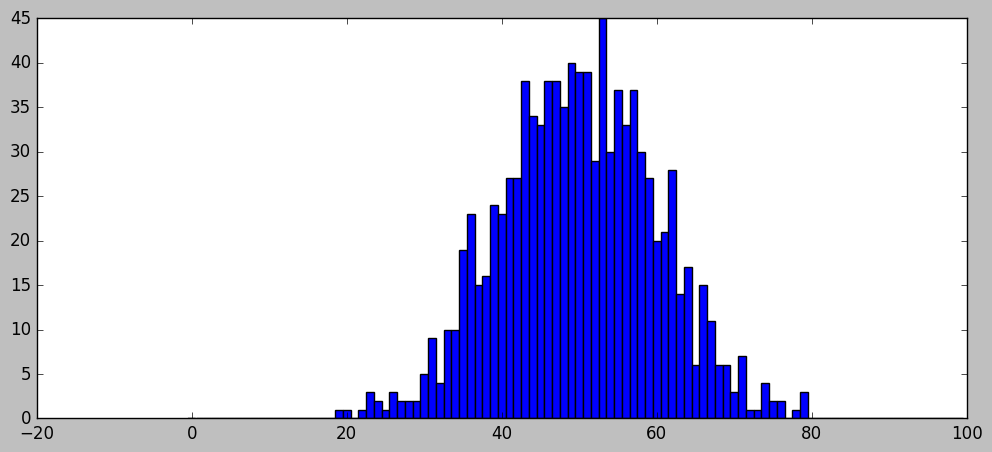

In [14]:
plt.hist(data, bins=np.arange(-0.5,100.5,1))
plt.show()

## Binomialverteilung ##


Die Wahrscheinlichkeit, dass sich bei einer Folge von $L$ gleichartigen und unabhängigen Bernoulli-Versuchen mit der Wahrscheinlichkeit $p$ $K$ Erfolge einstellen, wird durch eine Binomialverteilung mit den Parametern $L$ und $p$ angegeben:

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K} \text{ mit } K \in \mathbb{N}_0
$

Der Erwartungs- oder Mittelwert ist gegeben durch

$E(K) = \mu = pL$

und die Varianz durch

$Var(K) = \sigma^2 = pqL = p(p-1)L$ .

Händisch lässt sich $P(K, L, p)$ für größere $K, L$ kaum noch berechnen. In Python wird die Wahrscheinlichkeit durch die *probability mass function* `binom.pmf(K)` bestimmt, ansonsten kann man für $\sigma > 3$ die Binomialverteilung mit guter Genauigkeit durch die Normalverteilung annähern.




Mittelwert:	40.0
Std.abweichung:	5.656854249492381
Varianz:	32.0


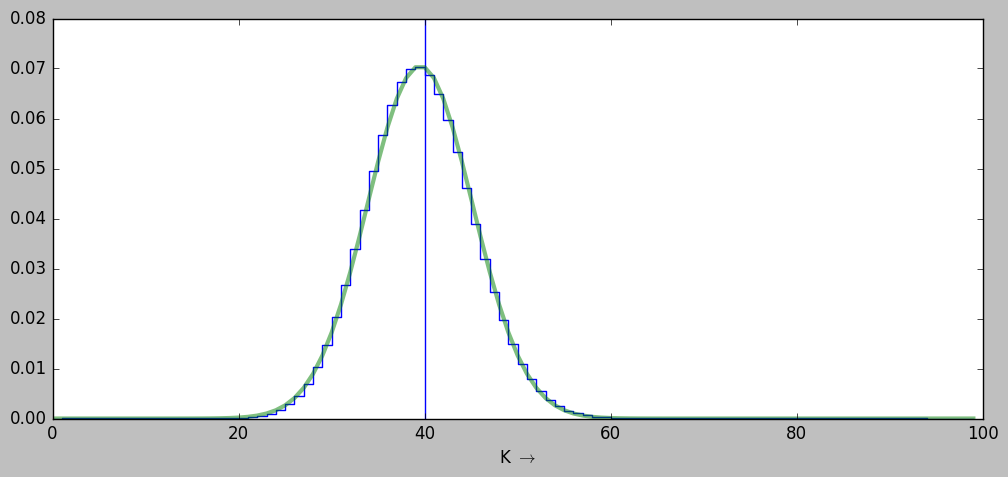

In [15]:
binom = scipy.stats.binom(n = 200, p = p)
K = np.arange(0, 100)
p_binom = binom.pmf(K)
m_binom = binom.mean()
s_binom = binom.std()
print("Mittelwert:\t{0}".format(m_binom))
print("Std.abweichung:\t{0}".format(binom.std()))
print("Varianz:\t{0}".format(binom.var()))
plt.step(K, p_binom)
plt.axvline(x=m_binom)
plt.xlabel(r"K $\rightarrow$")

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) # "frozen" distribution mit m und sigma
p_norm = norm.pdf(K+0.5) # continuous distribution, berechne probability density function
plt.plot(K, p_norm, lw = 3, alpha = 0.5)
plt.show()


Die Wahrscheinlichkeit, dass $S_i$ z.B. maximal 50 ist, erhält man aus der Verteilungsfunktion (*cumulative distribution function*, cdf). Diese Funktion lässt sich nicht geschlossen angeben, aber gut durch eine Fehlerfunktion annähern, wenn (Faustregel) die Varianz größer als 9 bzw. die Standardabweichung > 3 ist. Das ist in dem Beispiel hier gegeben. Die Verteilungsfunktionen in Python erhält man über die Methoden
`stats.binom.cdf()` bzw.
`stats.norm.cdf()`.

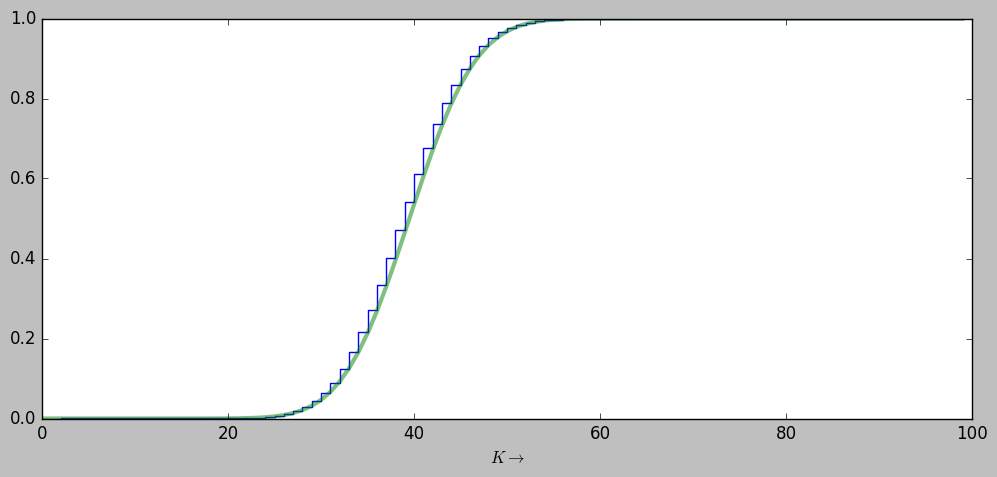

In [16]:
c_binom = binom.cdf(K)
plt.step(K, c_binom)
plt.xlabel(r"$K \rightarrow$")

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) 
c_norm = norm.cdf(K+0.5) # continuous distribution
plt.plot(K, c_norm, lw = 3, alpha = 0.5)
plt.show()

Die Frage am Anfang des Kapitels war ja: Wie groß ist die Wahrscheinlichkeit, dass 10 von 10 Experimenten einer Bernoulli - Verteilung mit $p = 0.2$ erfolgreich sind? Die mathematische Beschreibung ist 

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K}
$
mit $K = L = 10$. Es ist also $P(K=10, L=10, p=0.2) = 0.2^{10} = 1.024 \cdot 10^{-7}$

oder in Python: 

In [42]:
print("P(p=0.2, K=10, L=10) = 0.2^10\t= {0:g}".format(0.2**10))
print("binom.pmf(p=0.2, n=10, k=10) \t= {0:g}".format(scipy.stats.binom.pmf(p=0.2, n=10, k=10)))

P(p=0.2, K=10, L=10) = 0.2^10	= 1.024e-07
binom.pmf(p=0.2, n=10, k=10) 	= 1.024e-07


Ein Generator soll zunächst gleichverteilte Zufallszahlen im Bereich 1 ... 140 erzeugen. Die Auftretenswahrscheinlichkeit $P_i$ der einzelnen Zahlen $i$ soll mit $L$ Versuchen mit einem Histogramm mit $N = 140$ Bins geschätzt werden (der Erwartungswert ist hier einfach $E<Y_i> = L/N$). Dann soll die Wahrscheinlichkeit bestimmt werden, dass

a) ein Bin die Häufigkeit $\mu \pm 10 \%$ enthält und

b) *alle* Bins Zahlen im Bereich  $\mu \pm 10 \%$ enthalten.

Erwartungswert =	234.05714285714285 	(aus Stichprobe: 232.97857142857143)
Std.abweichung =	15.244189257630232
Minimum = 198, Maximum = 277
Delta Min/Max =		42.94285714285715	(2.816998425899416 Sigma)


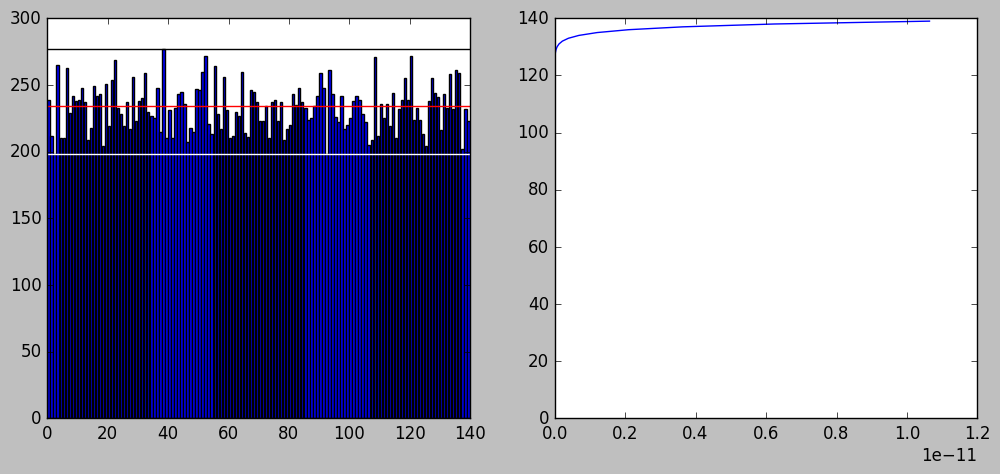

In [18]:
L = 2**15
N = 140
k = np.arange(1, N)
p = 1./140
size = 1000
T = 2.e-9
binom = scipy.stats.binom(n = L, p = p) # Binomialverteilung mit p = 1/N und L Bernoulli-Versuche
x_binom = binom.rvs(size=N) # N Versuche
m_binom = binom.mean()
s_binom = binom.std()

min_binom = binom.cdf(L/N *0.7)
max_binom = binom.cdf(L/N *1.3)

cdf = binom.cdf(k)

#print("Binomialverteilung:", x_binom)
print("Erwartungswert =\t{0} \t(aus Stichprobe: {1})".format(m_binom, np.sum(x_binom)/N))
print("Std.abweichung =\t{0}".format(s_binom))
print("Minimum = {0}, Maximum = {1}".format(min(x_binom), max(x_binom)))
Delta_max  = max(m_binom - min(x_binom), max(x_binom) - m_binom)
print("Delta Min/Max =\t\t{0}\t({1} Sigma)".format(Delta_max, Delta_max/s_binom))

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(121) 
ax1.bar(range(N), x_binom)
ax1.axhline(y=m_binom, color='r')
ax1.axhline(y=min(x_binom), color='w')
ax1.axhline(y=max(x_binom), color='k')
ax2 = fig1.add_subplot(122)
ax2.plot(cdf, k)
plt.show()